In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

Before we move on to the image classification, let's play around with a dataset of images. Specifically, we are going to play around with DataLoader and transformation.

# Download

We are going to use MNIST (http://yann.lecun.com/exdb/mnist/). I just want make sure that you have played around with MNIST dataset before.

Let's use torchvision to save time as it checks if the dataset has been downloaded and also check the md5 sum (integration check). 

In [2]:
from torchvision import datasets

training_set = datasets.MNIST(root='./',download=True,train=True)
test_set = datasets.MNIST(root='./',download=True,train=False)

Let's see what we just downloaded!

In [3]:
! tree MNIST

MNIST
├── processed
│   ├── test.pt
│   └── training.pt
└── raw
    ├── t10k-images-idx3-ubyte
    ├── t10k-images-idx3-ubyte.gz
    ├── t10k-labels-idx1-ubyte
    ├── t10k-labels-idx1-ubyte.gz
    ├── train-images-idx3-ubyte
    ├── train-images-idx3-ubyte.gz
    ├── train-labels-idx1-ubyte
    └── train-labels-idx1-ubyte.gz

2 directories, 10 files


If this is your first time playing around with MNIST, don't be shocked that you won't see familiar extensions, such as .jpg, .png, etc. In fact, after you extract the gz files, you''ll still serialized files. In the website, it is also mentioned that you need a custom script. Torchvision provides us with the processed folder when we can see the image data.

type training: <class 'tuple'>
(28, 28)


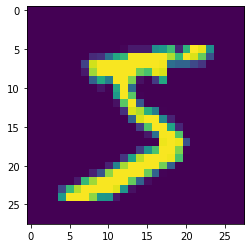

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

training = torch.load('./MNIST/processed/training.pt')
print('type training:', type(training))

idx_image = 1 # the first image
sample = training[0][idx_image-1].numpy()

print(sample.shape)
plt.imshow(sample)

Hmmm....it is not gray scale (in case you are wondering why it does not look like a typical image  as you have seen in other tutorials that use MNIST). 

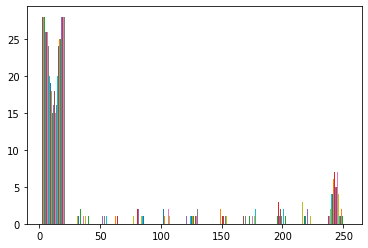

In [5]:
plt.hist(sample, bins='auto');

The histogram plot shows that the range of the values of the image is from 0 to 255.

By the way, you can do trial-and-error yourself, but eventually you might end up having a conclusion that the data structure needs to be a tensor (a 3D matrix), where: 
- the first dimension represents the row pixels, 
- the second dimension represents the column pixels, and
- the third dimension represent channels, e.g., red, blue, or green channels.

Long story short, let's transform into a 3D matrix having the pixel values from 0 to 1.

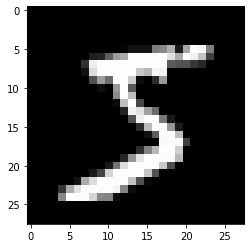

In [6]:
# Scale it to 0 to 1
sample_transformed = sample/sample.max()

# Transform it into a 3D matrix
# recall that 3*[1,2,3] = [1,2,3,1,2,3]
sample_transformed = np.array(3*[sample_transformed]) # but the shape is still (3,28,28)
sample_transformed = sample_transformed.transpose(1,2,0) # rearrange such that the zeroth index becomes the third and so on so forth

plt.imshow(sample_transformed)

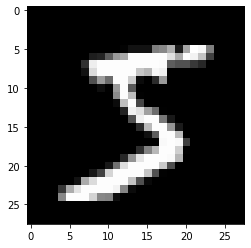

In [7]:
# Or using cmap from imshow. Too much hassle for this! 
# The point is that you'll notice that the data structure of images in numpy is [H,W,C],
# where H is height, W is width, and C is channel.
# Meanwhile in pytorch, they use [C,H,W]

# One more thing! With imshow, you need a proper [H,W,3] to draw a gray image

plt.imshow(sample,cmap='gray')

# DataLoader

DataLoader is one of PyTorch ways to do 'feature engineering'.

The idea with the DataLoader is that we want to load batch data relatively easily. In deep learning, a batch data (consisting of a set of images) will be loaded at each iteration within an epoch.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

training_set = datasets.MNIST(root='./',download=True,train=True,
                             transform=transforms.ToTensor()
                             )

training_loader = torch.utils.data.DataLoader(
    dataset=training_set, 
    batch_size=4,
)
# Note that dataset must be either map-style or iterable-style
# find more information on https://pytorch.org/docs/stable/data.html
# For example, iterable-style is the one you can do 'for i in something:' :D
# We'll discuss how to create our own custom dataset later




In [9]:
training_set_iter = iter(training_loader)
batch = training_set_iter.next() # this loads the first batch
len(batch[0])

4

You should see the batch size that we set before.

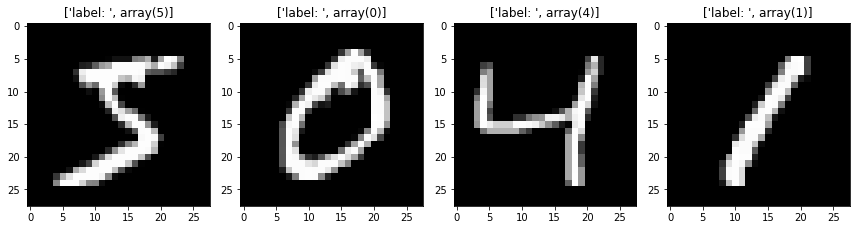

In [10]:
plt.figure(figsize=(12,16))

for i in range(len(batch[0])):
    image = batch[0][i].numpy().transpose(1,2,0)
    plt.subplot(1,len(batch[0]),i+1)
    plt.imshow(image, cmap='gray')
    plt.title(['label: ',batch[1][i].numpy()])
    plt.tight_layout()
    


Later you can load the training set as well as its label per batch 

# Custom Dataset

Let's create our own dataset. First, download a dataset of png files, for example, from http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

Specifically, we'll use http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz

You can write your script and refer to torchvision sources directly. There, you can learn how they download, extract, and transform it.

However, in case you do it manually. The following is the bash script that I use.

```sh
wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz
tar -xvf EnglishHnd.tgz English/Hnd/Img/Sample001/
mkdir CUSTOM_DATASET
find English/ -iname '*.png' -exec mv '{}' CUSTOM_DATASET/ \;
rm -rf English
```

In [11]:
#!bash ./download_EnglishHnd.sh # you can uncomment this to download and extract it

By the way, the md5sum of the tar file is 95e9ee6d929809ef4c2f509f86388c72 

Let's define our own custom dataset class with \__len__ and \__getitem__ methods. For the getitem method, we'll return a sample of an image in numpy format.  

In [12]:
import torch
from torch.utils.data import Dataset

import os
from skimage import io, transform
from skimage.color import rgb2gray

class CustomDataset(Dataset):
    
    def __init__(self,transform=None):
        self.list_image_name = os.listdir('CUSTOM_DATASET')
        self.transform = transform
        
    def __len__(self):
        return len(self.list_image_name)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        
        path = os.path.join('./CUSTOM_DATASET/',dataset.list_image_name[idx])
        image = io.imread(path)
        sample = {'image':image}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

Let's plot them!

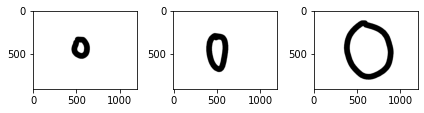

In [13]:
dataset = CustomDataset()

# I think 3 is sufficient
for i in range(3):
    
    img = dataset[i]['image']
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.tight_layout()



This definitely needs to be preprocessed before feeding it to our  model later. Why? Size is not the same (we need 28x28 for MNIST, i.e., the input layer size is 784). The color is also reversed (with MNIST we have a black background). 

In [14]:
class ToGray(object):
    """
    Example:
    tg = ToGray()
    tg(dataset[0])
    """
    
    def __call__(self,sample):
        image = sample['image']
        
        return {'image':1-rgb2gray(image)} # 1 - to invert
    
class Rescale(object):
    """
    see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img}

This is how you test it.

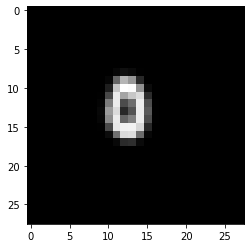

In [15]:
dataset = CustomDataset(
    transform=transforms.Compose([ToGray(),Rescale((28,28))])
)

plt.imshow(dataset[0]['image'],cmap='gray')


Now we can set a loader.

In [16]:
batch_size = 5

dataset_loader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=batch_size,
)

dataset_iter = iter(dataset_loader)
batch = dataset_iter.next() # this loads the first batch

print('batch size:',batch['image'].size())

batch size: torch.Size([5, 28, 28])


0it [00:00, ?it/s]

/tmp/ipykernel_109833/721721451.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(dataset)/batch_size,batch_size,batch_size*i+idx+1)


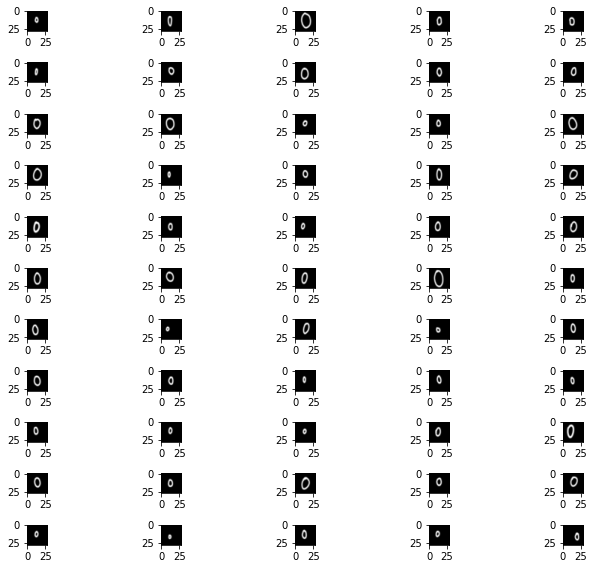

In [17]:
from tqdm.notebook import tqdm

plt.figure(figsize=(10, 8))

for i,batch in tqdm(enumerate(dataset_loader)):
    
    for idx in range(batch_size):
        plt.subplot(len(dataset)/batch_size,batch_size,batch_size*i+idx+1)
        plt.imshow(batch['image'][idx].numpy(),cmap='gray')

plt.tight_layout()

That's great. That should be enough about the feature engineering. You can explore yourself, esplecially with scikit-image library as you can find many different types of augmentations or transformations.

Now, let's return back to deep learning topic. In the next article, we are gonna use Deep NN to do the digit classification with MNIST dataset. 